In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.applications import imagenet_utils
from keras import Model
import warnings
from tensorflow.keras.preprocessing import image
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image
%matplotlib inline

2023-01-14 14:15:18.350128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 14:15:18.350226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Make the test directory
if os.path.isdir('test/buildings') is False:
    os.mkdir('test/')
    li = listdir('val/')
    for i in li:
        os.mkdir(f'test/{i}/')
        tempLi = listdir(f'val/{i}')
        for img in random.sample(tempLi,(5*len(tempLi))//100):
            shutil.move(f'val/{i}/{img}',f'test/{i}/')

In [3]:
train_path='train/'
valid_path='val/'
test_path='test/'
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,
                                                                                                                           target_size=(224,224),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,
                                                                                                                        target_size=(224,224),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,
                                                                                                                        target_size=(224,224),batch_size=10, shuffle = False)

Found 14034 images belonging to 6 classes.
Found 2853 images belonging to 6 classes.
Found 147 images belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

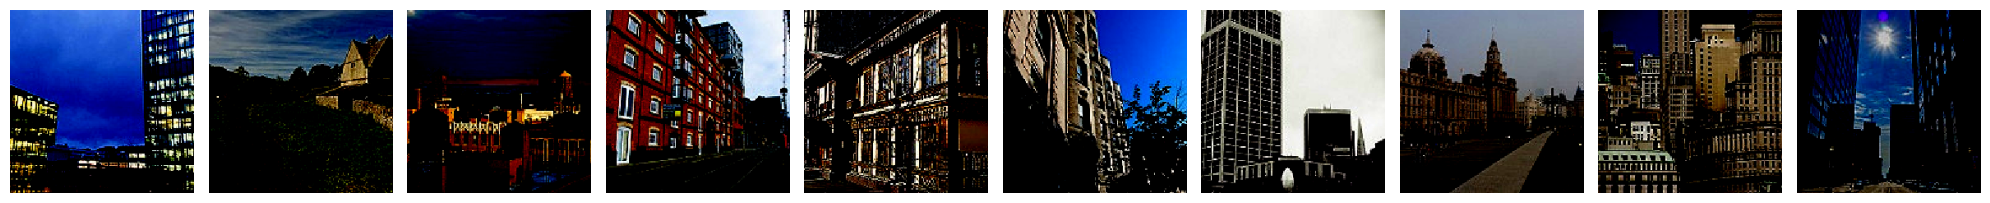

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [4]:
imgs, labels = next(test_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(imgs)
print(labels)

In [5]:
mobile=keras.applications.mobilenet.MobileNet()

2023-01-14 14:16:42.762254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 14:16:42.762374: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 14:16:42.762464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Aaryan): /proc/driver/nvidia/version does not exist
2023-01-14 14:16:42.764096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
newmodel = Sequential()
# Add all layers except the last one
for layer in mobile.layers[:-1]:
    newmodel.add(layer)

In [7]:
# This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of pizza/ non_pizza
for layer in newmodel.layers:
    layer.trainable = False

In [8]:
newmodel.add(Dense(units=6, activation='softmax'))

In [10]:
# Train the fine tuned mobilenet model
newmodel.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
newmodel.fit(x=train_batches,validation_data=valid_batches,epochs=15,verbose=2)

Epoch 1/15


KeyboardInterrupt: 

In [ ]:
# Prediction
newPred=newmodel.predict(x=test_batches,verbose=0)
newCm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(newPred,axis=1))
newPlotLabels= ['buildings','forest','glacier','mountain','sea','street']
plot_confusion_matrix(cm=newCm,target_names=newPlotLabels,title='Confusion Matrix',normalize=False)